# Regionalization considering variables used in PCA, 6 regions

In [1]:
from math import pi
import pandas as pd

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import robust_scale, minmax_scale
from sklearn.decomposition import PCA

import geopandas as gpd
from libpysal.weights import KNN

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

/home/dmitri/.local/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/dmitri/.local/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/dmitri/.local/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:198: NumbaDeprecationW

In [2]:
KNeighbors = 5
KClusters = 7

Read the data

In [3]:
ThailandMap = gpd.read_file("../../../Data/Enriched/ThailandMapProvinceIdRegion/ThailandMapProvinceIdRegion.shp")
ThailandMap = ThailandMap.rename(columns={'RegionInTh':'RegionInThai'})

ThailandMap['Region'] = ThailandMap['Region'].replace(
    {
        'NorthernThailand': 'Northern Thailand'
        , 'SouthernThailand': 'Southern Thailand'
        , 'WesternThailand': 'Western Thailand'
        , 'EasternThailand': 'Eastern Thailand'
        , 'NortheastThailand': 'Northeast Thailand'
        , 'CentralThailand': 'Central Thailand'
    }
)

ThailandMap = ThailandMap.sort_values('ProvinceId').reset_index(drop=True)

ThailandMapWithoutBkk = ThailandMap[ThailandMap['Name']!='Bangkok'].reset_index(drop=True)
ThailandMap = pd.concat([ThailandMapWithoutBkk, ThailandMap[ThailandMap['Name']=='Bangkok']]).reset_index(drop=True)

In [4]:
Dat = pd.read_csv("../../../Data/Processed/DataProvince.csv")
Dat = Dat.sort_values('ProvinceId').reset_index(drop=True)

Dat['MonthlyIncomeRatio2020'] = Dat['MonthlyIncomeQuantile80'] / Dat['MonthlyIncomeQuantile20']

Select the variables used in the PCA

In [5]:
Variables = [
    'MonthlyIncomeMean', 'MonthlyIncomeGiniIndex'
    , 'MonthlyIncomeRatio2020', 'IndicatorFormalDebtMean'
    , 'YearlySavingsPositiveMean', 'YearsOfEducation'
    , 'Indicator25Mean', 'Indicator23Mean', 'Indicator24Mean'
]

In [6]:
RenameVariables = {
    'MonthlyIncomeMean': "Monthly Income"
    , 'MonthlyIncomeGiniIndex': "Gini Index"
    , 'MonthlyIncomeRatio2020': "Income Ratio 20:20"
    , 'IndicatorFormalDebtMean': "Percent Formal Debt"
    , 'YearlySavingsPositiveMean': "Yearly Savings"
    , 'YearsOfEducation': "Years Of Education"
    , 'Indicator25Mean': "Smoking"
    , 'Indicator23Mean': "Having No Savings"
    , 'Indicator24Mean': "Alcohol Consumption"
}

In [7]:
DatVariables = Dat[Variables]
DatVariables = DatVariables.rename(columns=RenameVariables)

DatScaled = robust_scale(DatVariables)
DatScaled = pd.DataFrame(DatScaled, columns=DatVariables.columns)

DatVariables['ProvinceId'] = Dat['ProvinceId']

---

Agglomerative hierarchical clustering

In [8]:
WeightKnn = KNN.from_dataframe(ThailandMapWithoutBkk, k=KNeighbors)

In [9]:
Dendogram = AgglomerativeClustering(linkage="ward", connectivity=WeightKnn.sparse, n_clusters=KClusters)
Dendogram.fit(DatScaled)

DatVariables['Proposed Region'] = Dendogram.labels_

In [10]:
DatVariables.loc[DatVariables['Proposed Region'] == 5, 'Proposed Region'] = 1
DatVariables.loc[DatVariables['Proposed Region'] == 6, 'Proposed Region'] = 5

KClusters = 6

In [11]:
DictRegion = {
    0 : 'Southern Thailand',
    1 : 'Central Thailand',
    2 : 'Northern Thailand',
    3 : 'Bangkok - Pattaya',
    4 : 'Northeastern Thailand',
    5 : 'Northcentral Thailand'
}

In [12]:
DatVariables = DatVariables.replace({'Proposed Region':DictRegion})

In [13]:
#DatVariables[['ProvinceId', 'Proposed Region']].to_csv("../../../Data/Processed/ProposedRegions.csv", index=False)

---

Plot the proposed regions in the map

In [14]:
ThailandMap = pd.merge(
    ThailandMap
    , DatVariables[['ProvinceId', 'Proposed Region']]
    , how='left'
)

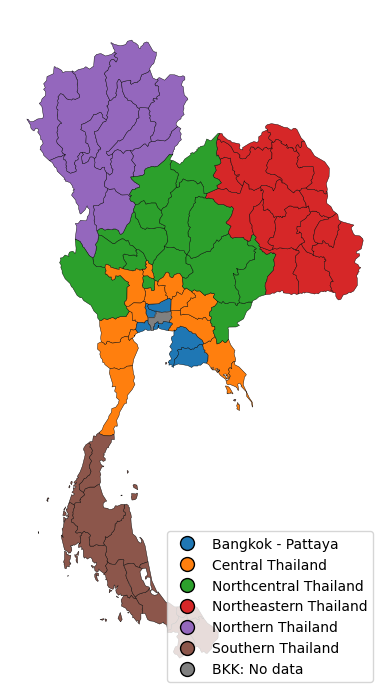

In [15]:
# Set up figure with two subplots in a row
f, ax = plt.subplots(1, 1, figsize=(4, 7.5), subplot_kw=dict(aspect="equal"))

ThailandMap.plot(
    'Proposed Region'
    , categorical = True
    , cmap = LinearSegmentedColormap.from_list('my_cmap', colors=plt.colormaps["tab10"].colors[:KClusters])
    , ax = ax
    , edgecolor = 'k'
    , linewidth = 0.3
    , legend = True
    , missing_kwds={'color':'grey', 'label':'BKK: No data'}
    , legend_kwds={'loc':'lower right'}
).set_axis_off()

for legend_handle in ax.get_legend().legend_handles:
    legend_handle.set_markeredgewidth(1)
    legend_handle.set_markeredgecolor('k')

f.tight_layout()

---

Biplot

In [16]:
PcaModel = PCA(n_components=2)
PcaFit = PcaModel.fit(DatScaled)
PcaDat = PcaFit.transform(DatScaled)
PcaDat = pd.DataFrame(PcaDat, columns=['PC1', 'PC2'])

In [17]:
DatVariables['PC1'] = PcaDat['PC1']
DatVariables['PC2'] = PcaDat['PC2']

In [18]:
PcaLoads = PcaFit.components_
PcaLoads = pd.DataFrame(PcaLoads.T, columns=['PCA1', 'PCA2'])
PcaLoads['Variable'] = list(DatScaled)
PcaLoads = PcaLoads.set_index('Variable')

In [19]:
DatRegionPca = DatVariables[['PC1', 'PC2', 'Proposed Region']].groupby('Proposed Region').mean().reset_index()

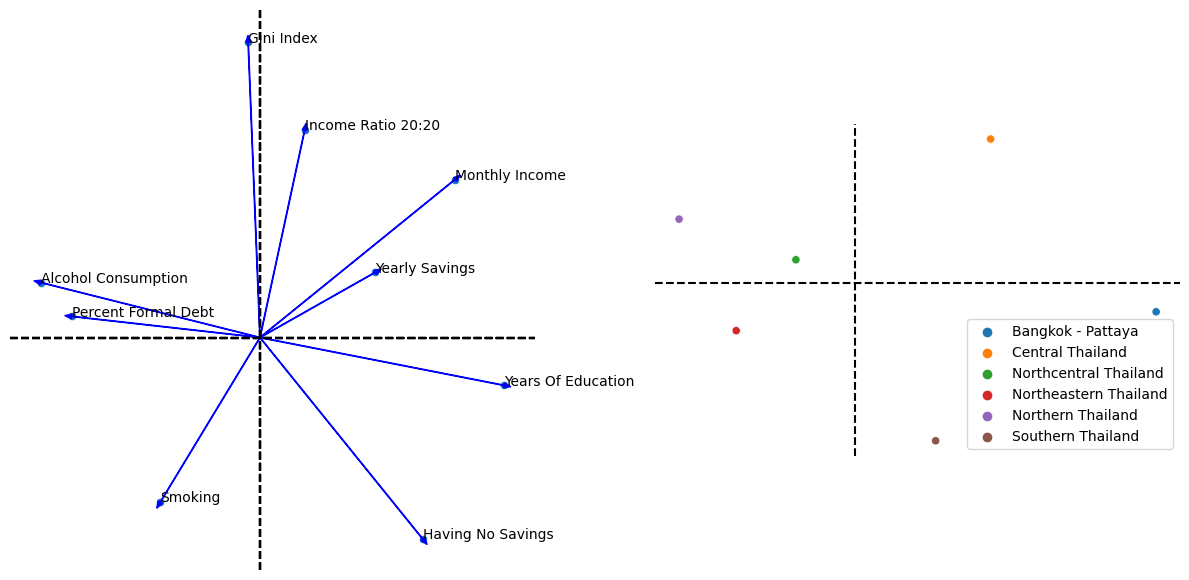

In [20]:
f, axs = plt.subplots(1, 2, figsize=(12,6), subplot_kw=dict(aspect="equal"))

ax = axs[0]
sns.scatterplot(data=PcaLoads, x='PCA1', y='PCA2', ax=ax)

for i in range(len(PcaLoads)):

    ax.arrow(
        0, 0, # coordinates of arrow base
        PcaLoads.iloc[i]['PCA1'], # length of the arrow along x
        PcaLoads.iloc[i]['PCA2'], # length of the arrow along y
        color='b', 
        head_width=0.01
    )

    ax.text(PcaLoads.iloc[i]['PCA1'], PcaLoads.iloc[i]['PCA2'], PcaLoads.index[i])

    ax.axvline(0, color='k', linestyle='--')
    ax.axhline(0, color='k', linestyle='--')

ax.axis('off')

ax= axs[1]
sns.scatterplot(data=DatRegionPca, x='PC1', y='PC2', hue='Proposed Region', ax=ax, palette='tab10')

ax.axvline(0, color='k', linestyle='--')
ax.axhline(0, color='k', linestyle='--')

ax.legend(loc='lower right')
ax.axis('off')

f.tight_layout()

---

Radar chart

In [21]:
DatClusterAhc = DatVariables[['Years Of Education', 'Monthly Income', 'Yearly Savings', 'Having No Savings', 'Income Ratio 20:20', 'Gini Index', 'Percent Formal Debt', 'Alcohol Consumption', 'Smoking', 'Proposed Region']]

DatClusterAhc = DatClusterAhc.groupby('Proposed Region').mean()

In [22]:
DatClusterAhcScaled = pd.DataFrame(minmax_scale(DatClusterAhc), columns=DatClusterAhc.columns, index=DatClusterAhc.index)

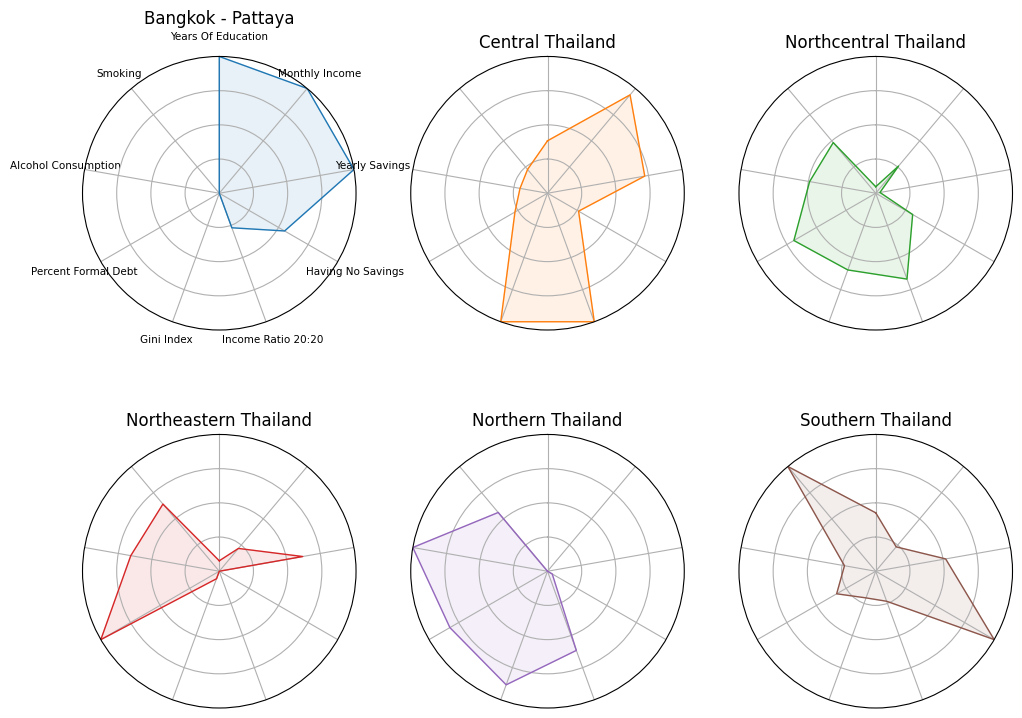

In [23]:
# Number of variable
categories=list(DatClusterAhcScaled)
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
f, axs = plt.subplots(2, 3, subplot_kw={'projection': 'polar'}, figsize=(12, 9))

for i, ax in enumerate(axs.flat):

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    if i ==0:    
        # Draw one axe per variable + add labels
        ax.set_xticks(angles[:-1], categories, size=7.5)
    else:
        ax.set_xticks(angles[:-1], [])
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    ax.set_yticks([0.25,0.5,0.75], [], color="grey", size=7)
    ax.set_ylim(0,1)

    # Add plots
    ax.plot(
        angles
        , list(DatClusterAhcScaled.iloc[i]) + [DatClusterAhcScaled.iloc[i][0]]
        , color=plt.colormaps["tab10"].colors[:KClusters][i]
        , linewidth=1
        , linestyle='solid'
        #, label="region " + str(i)
    )

    ax.fill(
        angles
        , list(DatClusterAhcScaled.iloc[i]) + [DatClusterAhcScaled.iloc[i][0]]
        , color=plt.colormaps["tab10"].colors[:KClusters][i]
        , alpha=0.1
    )

    ax.set_title(DatClusterAhcScaled.index[i])